In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle

In [ ]:
with open("/content/drive/MyDrive/dataset/train.pkl", "rb") as f:
    x_train, y_train = pickle.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/test.pkl", "rb") as f:
    x_test, y_test = pickle.load(f)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2100, 299, 299, 3)
(2100, 3)
(900, 299, 299, 3)
(900, 3)


In [ ]:
!pip install keras==2.1.2
!pip install tensorflow==1.14.0
!pip install h5py==2.10.0

     |████████████████████████████████| 304 kB 10.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.7.0 requires keras<2.8,>=2.7.0rc0, but you have keras 2.1.2 which is incompatible.
     |████████████████████████████████| 109.3 MB 8.8 kB/s 
     |████████████████████████████████| 488 kB 75.7 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 3.1 MB 72.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7

In [ ]:
import tensorflow as tf


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers, initializers

K.set_image_data_format('channels_last')

def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (1 + s_squared_norm)
    return scale * x


def softmax(x, axis=-1):
    
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


def margin_loss(y_true, y_pred):
    
    lamb, margin = 0.5, 0.1
    return K.sum((y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin))), axis=-1)


class Capsule(Layer):
    

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = int(input_shape[-1])
        if self.share_weights:
            self.kernel = self.add_weight(name='capsule_kernel', shape=(1, input_dim_capsule, self.num_capsule * self.dim_capsule), initializer=initializers.get('glorot_uniform'))
        else:
            input_num_capsule = int(input_shape[-2])
            self.kernel = self.add_weight(name='capsule_kernel', shape=(input_num_capsule, input_dim_capsule, self.num_capsule * self.dim_capsule), initializer=initializers.get('glorot_uniform'))

    def call(self, inputs):

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                print(o)
                print(hat_inputs)
                b += K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
        }
        base_config = super(Capsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


batch_size = 10
num_classes = 3
epochs = 20

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Model/train/architecture/model_caps28.hd5', custom_objects={'Capsule':Capsule, 'margin_loss':margin_loss})


Tensor("capsule_6_2/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6_2/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_6_2/mul_1:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6_2/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7_2/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7_2/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7_2/mul_1:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7_2/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_8_2/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8_2/transpose:0", shape=(?, 3, ?, 16), dtype=float32)
Tensor("capsule_8_2/mul_1:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8_2/transpose:0", shape=(?, 3, ?, 16), dtype=float32)


In [ ]:
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      self.model.save("/content/drive/MyDrive/Model/train/architecture/model_caps"+str(epoch)+".hd5")
      self.model.save_weights("/content/drive/MyDrive/Model/train/weights/model_weights"+str(epoch)+".hd5")

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

In [ ]:
saver = CustomSaver()
model.fit(x_train, y_train, 
          batch_size=batch_size,
          epochs=29,
          shuffle=True,
          validation_data=(x_test,y_test),
          callbacks=[saver, es],
          initial_epoch=27)

Train on 2100 samples, validate on 900 samples
Epoch 28/29
2100/2100 [==============================] - 3549s 2s/sample - loss: 0.0419 - acc: 0.9400 - val_loss: 0.1226 - val_acc: 0.8333
Epoch 29/29
2100/2100 [==============================] - 3588s 2s/sample - loss: 0.0398 - acc: 0.9390 - val_loss: 0.0450 - val_acc: 0.9322


In [ ]:
model.save("/content/drive/MyDrive/Model/train.hd5")
model.save_weights("/content/drive/MyDrive/Model/train_weights.hd5")

In [ ]:
x_test.shape

(900, 299, 299, 3)

In [ ]:
actual = []
predictions = []
x = 0
y = 0
while x+1<900:
  res = model.predict([x_test[x:x+1]])
  actual.append(np.argmax(y_test[x:x+1]))
  predictions.append(np.argmax(res))
  y+=1
  x+=1

In [ ]:
actual = np.array(actual)
predictions = np.array(predictions)
print(actual)
print(predictions)

[0 1 0 2 2 0 1 1 0 0 2 1 2 2 1 1 1 2 1 2 0 1 2 0 2 1 0 0 2 1 1 1 2 0 2 2 1
 0 1 0 2 2 2 2 1 0 0 1 2 2 1 0 1 1 1 2 2 0 2 2 0 1 1 0 2 1 0 0 2 2 2 1 2 0
 2 2 0 0 1 0 1 0 2 2 2 2 0 0 2 2 2 1 0 1 1 1 0 2 2 2 2 0 2 0 2 2 1 2 1 1 0
 0 1 0 1 2 1 0 2 2 2 0 1 1 2 1 1 2 1 0 1 0 1 0 2 2 0 2 2 2 2 0 2 0 2 2 0 2
 1 0 0 1 1 2 1 2 2 2 0 2 0 1 1 2 0 0 0 0 1 1 1 0 2 0 2 2 0 0 0 0 0 0 0 1 0
 1 2 1 1 0 1 1 1 1 1 2 2 0 0 2 1 2 0 0 1 0 0 1 1 2 2 1 0 2 1 1 0 0 2 0 2 1
 0 1 2 2 0 1 0 1 0 1 0 0 2 1 1 1 0 0 2 1 2 0 0 0 2 1 2 0 1 1 1 0 2 2 1 0 2
 0 0 0 2 0 0 2 2 2 1 2 0 0 1 1 2 2 1 1 0 0 1 0 2 0 1 2 1 0 0 1 1 2 2 0 1 2
 2 1 1 2 1 2 1 2 1 2 1 0 1 2 0 2 1 2 0 2 1 1 0 0 1 2 1 1 0 1 0 0 0 1 0 2 1
 0 1 0 0 2 2 2 2 1 1 2 0 1 1 0 2 1 2 0 1 1 2 1 2 1 0 1 0 0 0 2 2 2 2 0 1 1
 0 0 2 1 2 0 0 0 1 1 0 2 2 0 1 2 2 1 0 1 1 1 1 1 0 2 1 1 1 2 0 1 1 0 2 0 0
 0 1 0 2 2 1 0 2 2 0 1 2 2 0 1 2 0 1 1 2 2 0 2 2 1 1 2 2 2 0 1 0 0 2 1 2 0
 0 1 0 0 0 2 2 2 0 1 1 2 2 2 2 2 2 0 0 2 2 0 2 0 1 0 1 1 2 0 2 2 1 1 1 1 2
 1 1 2 0 0 2 0 0 0 1 2 1 

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Covid19', 'Pneumonia', 'Normal']
print(classification_report(actual, predictions, target_names=target_names))

              precision    recall  f1-score   support

     Covid19       0.93      0.94      0.93       285
   Pneumonia       0.93      0.98      0.95       300
      Normal       0.94      0.89      0.91       314

    accuracy                           0.93       899
   macro avg       0.93      0.93      0.93       899
weighted avg       0.93      0.93      0.93       899



In [ ]:
clf_report = classification_report(actual, predictions, target_names=target_names, output_dict=True)
clf_report

{'Covid19': {'f1-score': 0.9335664335664337,
  'precision': 0.9303135888501742,
  'recall': 0.9368421052631579,
  'support': 285},
 'Normal': {'f1-score': 0.9099836333878888,
  'precision': 0.936026936026936,
  'recall': 0.8853503184713376,
  'support': 314},
 'Pneumonia': {'f1-score': 0.9528455284552846,
  'precision': 0.9301587301587302,
  'recall': 0.9766666666666667,
  'support': 300},
 'accuracy': 0.932146829810901,
 'macro avg': {'f1-score': 0.9321318651365357,
  'precision': 0.9321664183452801,
  'recall': 0.9329530301337208,
  'support': 899},
 'weighted avg': {'f1-score': 0.9317630177828877,
  'precision': 0.9322574524831777,
  'recall': 0.932146829810901,
  'support': 899}}

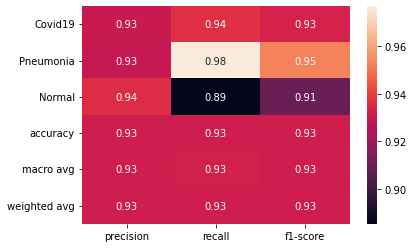

In [ ]:
import seaborn as sns
import pandas as pd
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

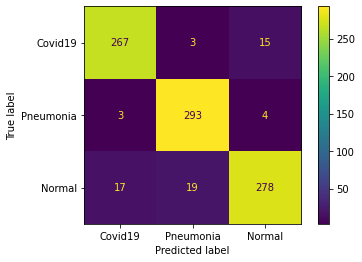

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)
cmd.plot()